![DSME-logo](./static/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---
Authors: Jyotirmaya Patra, Ramil Sabirov

Adapted from: [CleanRL](https://github.com/vwxyzjn/cleanrl)

Orignal Paper: [Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor
](https://arxiv.org/abs/1801.01290#)

Variation of the Orignal Paper on which the notebook is based: [Soft Actor-Critic Algorithms and Applications
](https://arxiv.org/abs/1812.05905)

Additional References:
1. Generalised Advantage Estimate:
    * [High-Dimensional Continuous Control Using Generalized Advantage Estimation](https://arxiv.org/abs/1506.02438)
2. OpenAI SpinningUp:
    * [Soft Actor-Critic](https://spinningup.openai.com/en/latest/algorithms/sac.html)


## Library Imports

In [1]:
import os
import time
import random
import warnings
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from tqdm import notebook
from easydict import EasyDict as edict
from IPython.display import Video

import utils.helper_fns as hf

import gym
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from stable_baselines3.common.buffers import ReplayBuffer

warnings.filterwarnings("ignore", category=DeprecationWarning)

os.environ['SDL_VIDEODRIVER'] = 'dummy'
os.environ['WANDB_NOTEBOOK_NAME'] = 'sac.ipynb'

plt.rcParams['figure.dpi'] = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

## Initializations

### Experiment

We primarily use dictionaries for initializing experiment parameters and training hyperparameters. We use the `EasyDict` (imported as `edict`) library, which allows us to access dict values as attributes while retaining the operations and properties of the original python `dict`! [[Github Link](https://github.com/makinacorpus/easydict)]

In this notebook we use a few `edicts` with `exp` being one of them. It is initialized in the following cell and has keys and values containing information about the experiment being run. Although initialized in this section, we keep adding new keys and values to the dict in the later sections as well.  

This notebook supports continuous gym environments with observation space of type `gym.spaces.Box` and action space of type `gym.spaces.Box`. Eg: Pendulum-v1, MountainCarContinuous-v0, BipedalWalker-v3, LunarLanderContinuous-v2

In [2]:
exp = edict()

exp.exp_name = 'SAC'  # algorithm name, in this case it should be 'SAC'
exp.env_id = 'Pendulum-v1'  # name of the gym environment to be used in this experiment. Eg: Pendulum-v1, BipedalWalker-v3
exp.device = device.type  # save the device type used to load tensors and perform tensor operations

exp.random_seed = True  # set random seed for reproducibility of python, numpy and torch
exp.seed = 1

# name of the project in Weights & Biases (wandb) to which logs are patched. (only if wandb logging is enabled)
# if the project does not exist in wandb, it will be created automatically
wandb_prj_name = f"RLLBC_{exp.env_id}"

# name prefix of output files generated by the notebook
exp.run_name = f"{exp.env_id}__{exp.exp_name}__{exp.seed}__{datetime.now().strftime('%y%m%d_%H%M%S')}"

if exp.random_seed:
    random.seed(exp.seed)
    np.random.seed(exp.seed)
    torch.manual_seed(exp.seed)
    torch.backends.cudnn.deterministic = exp.random_seed

### Agent Model Class


The `Agent` class consists of two different architectures of neural networks: a network architecture for the actor (`ActorNetwork`) and a network architecture for the Q-values (`QNetwork`). The Q-network takes state and action as input and evaluates to a scalar value that approximates the expected return until the end of the episode. The actor network takes the state as input and evaluates to a (multidimensional) gaussian distribution by specifying mean and (logarithm of) standard deviation. The logarithm of the standard deviation is bounded by a specified interval. Just as in [TD3](https://arxiv.org/abs/1802.09477), to counteract the overestimation of Q-values, SAC uses two Q-networks instead of one.

The `Agent` class uses target networks to stabilize the learning process. In particular, it holds a target network for both Q-networks. The class provides methods to query the four different Q-networks, i.e. `get_q1_value`, `get_target_q1_value`, `get_q2_value`, and `get_target_q2_value`. The class also provides methods to query the actor network: `get_action` samples an action for a state according to the computed gaussian distribution and `get_action_and_logprob` additionally outputs the logarithm of the gaussian for the sampled action as well as the mean action. The sampled action is always first transformed to $[-1,1]$ by a hyperbolic tangent before it is scaled to the desired action space range.

Note that the target networks will not be subject to the optimizer, meaning they will not be modified through gradient steps. Instead, the `Agent` class provides the function `track_networks` to make the parameters of the target networks slowly track the parameters of the learned networks by the linear combination $\theta^t \leftarrow \tau\theta + (1-\tau)\theta^t$ with $\tau \ll 1$.

In [3]:
class Critic(nn.Module):
    def __init__(self, env):
        super().__init__()

        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod() + np.prod(env.single_action_space.shape, dtype=int), 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x, a):
        x = torch.cat([x, a], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()

        self.LOG_STD_MAX = 2
        self.LOG_STD_MIN = -5

        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 64)
        self.fc2 = nn.Linear(64, 64)
        self.act = F.relu
        self.fc_mean = nn.Linear(64, np.prod(env.single_action_space.shape, dtype=int))
        self.fc_logstd = nn.Linear(64, np.prod(env.single_action_space.shape, dtype=int))

        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = self.LOG_STD_MIN + 0.5 * (self.LOG_STD_MAX - self.LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

In [4]:
class Agent(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.q1_net = Critic(env)
        self.q2_net = Critic(env)
        self.target_q1_net = Critic(env)
        self.target_q2_net = Critic(env)
        self.actor_net = Actor(env)

        self.target_q1_net.load_state_dict(self.q1_net.state_dict())
        self.target_q2_net.load_state_dict(self.q2_net.state_dict())

    def get_q1_value(self, x, a):
        return self.q1_net(x, a)

    def get_q2_value(self, x, a):
        return self.q2_net(x, a)

    def get_target_q1_value(self, x, a):
        return self.target_q1_net(x, a)

    def get_target_q2_value(self, x, a):
        return self.target_q2_net(x, a)

    def get_action(self, x, greedy=False):
        mean, log_std = self.actor_net(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        if not greedy:
            x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        else:
            x_t = mean  # greedy action
        y_t = torch.tanh(x_t)
        action = y_t * self.actor_net.action_scale + self.actor_net.action_bias

        return action

    def get_action_and_logprob(self, x):
        mean, log_std = self.actor_net(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.actor_net.action_scale + self.actor_net.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.actor_net.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.actor_net.action_scale + self.actor_net.action_bias
        return action, log_prob, mean

    def update_target_networks(self, tau):
        for param, target_param in zip(self.q1_net.parameters(), self.target_q1_net.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for param, target_param in zip(self.q2_net.parameters(), self.target_q2_net.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

### Training Params & Agent Hyperparams

The second dictionary we use, `hypp`, is initialized in the following cell. It has keys and values containing the hyperparameters necessary to the algorithm.

The parameters and hyperparameters in this section are broadly categorized as below:
1. Flags for logging: 
    - They are stored in the `exp` dict. 
    - This notebook uses tensorboard logging by deafult to log experiment metrics. These tb log files are saved in the directory `logs/<exp.exp_type>/<exp.run_name>/tb`. (to learn about `exp.exp_type` refer point 3. below)
    - To enable logging of gym videos of the agent's interaction with the env set `exp.capture_video = True`
    - Patch tensorboard logs and gym videos to Weigths & Biases (wandb) by setting `exp.enable_wandb_logging = True`
2. Flags and parameters to generate average performance throughout training:
    - Stored in the `exp` dict
    - If `exp.eval_agent = True`, the performance of the agent during it's training is saved in the corresponding logs folder. You can later used this to compare the performance of your current agent with other agents during their training (in Section 1.5.2).
    - Every `exp.eval_frequency` episodes the trained agent is evaluated using the `envs_eval` by playing out `exp.eval_count` episodes
    - To speed up training set `exp.eval_agent = False` 
3. Create experiment hierarchy inside log folders:
    - if `exp.exp_type` is None, experiment logs are saved to the root log directory `logs`, ie, `/logs/<exp.run_name>`, otherwise they are saved to the directory `logs/<exp.exp_type>/<exp._name>`
4. Parameters and hyperparameters related to the algorithm:
    - Stored in the `hypp` dict
    - Quick reminder:  the `num_steps` key in the `hypp` dict is also a hyperparameter defined in Env & Rollout Buffer Init Section.

Note: 
1. If Weigths and Biases (wandb) logging is enabled, when you run the "Training The Agent" cell, enter your wandb's api key when prompted. 
2. Training takes longer when either gym video recording or agent evaluation during training is enabled. To speed up training set both `exp.capture_video` and `exp.eval_agent` to `False`.

In [5]:
hypp = edict()

# env count
exp.num_envs = 1  # currently replaybuffer from SB3 supports only single environment

# flags for logging purposes
exp.enable_wandb_logging = True
exp.capture_video = True  # disable to speed up training

# flags to generate agent's average performance during training
exp.eval_agent = True  # disable to speed up training
exp.eval_count = 10
exp.eval_frequency = 20
exp.device = device.type

# putting the run into the designated log folder for structuring
exp.exp_type = None  # directory the run is saved to. Should be None or a string value

# agent training specific parameters and hyperparameters
hypp.total_timesteps = 100000  # the training duration in number of time steps
hypp.learning_starts = 5000  # timestep after which gradient descent updates begins
hypp.buffer_size = 10000  # size of replay buffer
hypp.batch_size = 256  # number of minibatches for gradient updates

hypp.gamma = 0.99  # discount factor over future rewards
hypp.tau = 0.005  # smoothing coefficient for target q neworks parameters
hypp.exploration_noise = 0.1  # the scale of exploration noise
hypp.policy_lr = 3e-4  # learning rate of the policy network optimizer
hypp.q_lr = 1e-3  # learning rate of the Q network network optimizer
hypp.policy_frequency = 2  # frequency of training policy (delayed)
hypp.target_network_frequency = 1  # frequency of updates for the target networks
hypp.alpha = 0.2  # Entropy regularization coefficient
hypp.autotune = True  # automatic tuning of the entropy coefficient

### Replay Buffer

In the following cell the **replay buffer** is initialised. It is used in 2 ways:
- It **stores transitions** the agent took in the environment in the past (i.e. (state, action, next_state, reward, done?) tuples)
- It is possible to **sample a batch** of transitions from the replay buffer. The batch is used to perform a gradient step on for training.

In [6]:
envs = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(exp.num_envs)])

rb = ReplayBuffer(
    int(hypp.buffer_size),
    envs.single_observation_space,
    envs.single_action_space,
    device,
    handle_timeout_termination=True,
)

### Training the Agent

Before we begin training the agent, we first initialize the logging (based on the respective flags in the `exp` dict), the object of the `Agent` class and the optimizers: one for the Q-networks, one for the actor, and possibly one for tuning the entropy coefficient $\alpha$. We also initialize an initial set of observations.

After that follows the main training loop which consists of an initial **warm-up phase** followed by the **training phase**. In the warm-up phase we sample random trajectories to fill the replay buffer with observations. After that we enter the training phase which consists of:
1. **Taking a step in the environment** according to the policy defined by the actor network.
2. **Sampling a minibatch from the replay buffer** of previously experienced transitions. These are tuples of the form $(s,a,s',r,d)$=(state, action, next_state, reward, done) where done is a boolean indicating whether the environment has terminated after the transition.
3. **Optimizing the Q-networks** by:
    1. Sampling the target actions $\tilde{a}_i$ in the states $s'_i$ of the minibatch from the policy network $\pi$
    2. Calculating the targets for each transition in the minibatch. Let $Q_j'(s,a)$ denote the Q-value of the $j$-th target network in state $s$ for action $a$, then the target $T_i$ for transition $i$ of the minibatch is:  
    <br>$$\begin{equation}T_i =
\begin{cases}
r_i + \min_{j=1,2}Q_j'(s'_i,\tilde{a}_i) - \alpha\log (\pi(s'_i, \tilde{a}_i)) &, \text{if } d_i = 0\\
r_i &, \text{else}
\end{cases}
\end{equation}$$  

    3. Setting up the Q-loss functions $L_{Q_j}$ as a mean squared error (MSE) between Q-values and computed targets. Let $Q_j(s,a|\theta^{Q_j})$ be the Q-value of the $j$-th Q-network for state $s$ and action $a$, then for $j=1,2$ the Q-losses are:  
    <br>$$L_{Q_j} = \frac{1}{m}\sum_{i=1}^{m}(Q(s_i,a_i|\theta^{Q_j}) - T_i)^2$$  
    
    4. Performing a gradient descent step for the parameters of the Q-networks $\theta^{Q} = \bigcup_{j=1,2}\theta^{Q_j}$ along the gradient $\nabla_{\theta^Q} L_{Q_1} + L_{Q_2}$.
4. **Optimizing the actor network** by:
    1. Computing the policy loss $L_\pi$ for the minibatch. Let $\tilde{a}_i \sim \pi(\cdot|s_i; \theta^{\pi})$ be the actions sampled (once again) by the actor network $\pi$ in states $s_i$, then the policy loss is:  
    <br>$$L_{\pi} = \frac{1}{m}\sum_{i=1}^m\left( \alpha\log\pi(s_i, \tilde{a}_i|\theta^{\pi})-\min_{j=1,2}Q_j(s_i,\tilde{a}_i)\right)$$  
    
    2. Performing a gradient descent step for parameters of actor network $\theta^\pi$ along the gradient $\nabla_{\theta^\pi} L_\pi$.
    
5. **Tuning the temperature parameter $\alpha$** by:
    1. Setting up a loss function $L_{\alpha}$ for the minibatch. Again, for the sampled actions $\tilde{a}_i \sim \pi(\cdot|s_i)$ from the actor network $\pi$ in states $s_i$, we arrive at the loss: $$L_{\alpha} = \frac{1}{m}\sum_{i=1}^m -\alpha * (\log\pi(s_i, \tilde{a}_i) + \bar{H})$$ where $\bar{H}$ is a specified target entropy.
    2. Performing a gradient descent step for the parameter $\alpha$ along the gradient $\nabla_{\alpha} L_{\alpha}$.  
      
      Note: for numerical reasons, rather than tuning $\alpha$ directly, this implementation tunes its logarithm. The actually implemented formulas can be obtained by replacing $\alpha$ by $\log\alpha$.
    
6. **Updating the target networks** by letting them track the parameters of the learned networks.

Note that steps 4 to 6 are generally not performed in every step of the main loop but in a delayed fashion.

Post completion of the main training loop, we save a copy of the following in the directory `logs/<exp.exp_type>/<exp.run_name>`:
1. `exp` and `hypp` dicts into a `.config` file 
2. `agent` (instance of `Agent` class) into a `.pt` file for later evaluation
3. agent performance progress throughout training into a `.csv` file if `exp.eval_agent=True`

Note: we have two vectorised gym environments, `envs` and `envs_eval` in the initalizations. `envs` is used to fill the rollout buffer with trajectories and `envs_eval` is used to evaluate the agent performance at different stages of training.

In [7]:
# reinit run_name
exp.run_name = f"{exp.env_id}__{exp.exp_name}__{exp.seed}__{datetime.now().strftime('%y%m%d_%H%M%S')}"

# Init tensorboard logging and wandb logging
writer = hf.setup_logging(wandb_prj_name, exp, hypp)

# create two vectorized envs: one to fill the rollout buffer with trajectories, and
# another to evaluate the agent performance at different stages of training
envs.close()
envs = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(exp.num_envs)])
envs_eval = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(exp.eval_count)])

# envs.single_observation_space.dtype = np.float32

# init list to track agent's performance throughout training
tracked_returns_over_training = []
tracked_episode_len_over_training = []
tracked_episode_count = []
last_evaluated_episode = None  # stores the episode_step of when the agent's performance was last evaluated
greedy_evaluation = True  # whether to perform the evaluation in a greedy way or not
eval_max_return = -float('inf')

agent = Agent(envs).to(device)
q_optimizer = optim.Adam(list(agent.q1_net.parameters()) + list(agent.q2_net.parameters()), lr=hypp.q_lr)
actor_optimizer = optim.Adam(agent.actor_net.parameters(), lr=hypp.policy_lr)

global_step = 0
episode_step = 0
gradient_step = 0

# Automatic entropy tuning
if hypp.autotune:
    target_entropy = -torch.prod(torch.Tensor(envs.single_action_space.shape).to(device)).item()
    log_alpha = torch.zeros(1, requires_grad=True, device=device)
    alpha = log_alpha.exp().item()
    a_optimizer = optim.Adam([log_alpha], lr=hypp.q_lr)
else:
    alpha = hypp.alpha

# Init observation to start learning
start_time = time.time()
obs = torch.Tensor(envs.reset()).to(device)

pbar = notebook.tqdm(range(hypp.total_timesteps))

# training loop
for global_step in pbar:

    # collect trajectories; sample action randomly if learning/gradient updates has not begun
    if global_step < hypp.learning_starts:
        actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
    else:
        # actions, _, _ = agent.get_action(torch.Tensor(obs).to(device))
        actions = agent.get_action(torch.Tensor(obs).to(device))
        actions = actions.detach().cpu().numpy()

    # execute the game and log data
    next_obs, rewards, dones, infos = envs.step(actions)
    real_next_obs = next_obs.copy()

    # record rewards for plotting purposes at the end of every episode
    for idx, info in enumerate(infos):
        if "episode" in info.keys():
            pbar.set_description(f"global_step={global_step}, episodic_return={info['episode']['r']:.3f}")
            writer.add_scalar("rollout/episodic_return", info["episode"]["r"], global_step+idx)
            writer.add_scalar("rollout/episodic_length", info["episode"]["l"], global_step+idx)
            writer.add_scalar("Charts/episode_step", episode_step, global_step)
            writer.add_scalar("Charts/gradient_step", gradient_step, global_step)
            episode_step += 1

        # handle `terminal_observation`
        if dones[idx]:
            real_next_obs[idx] = info["terminal_observation"]

    # save data to reply buffer
    rb.add(obs, real_next_obs, actions, rewards, dones, infos)

    obs = next_obs

    # generate average performance statistics of current learned agent
    if exp.eval_agent and episode_step % exp.eval_frequency == 0 and last_evaluated_episode != episode_step:
        last_evaluated_episode = episode_step
        tracked_return, tracked_episode_len = hf.evaluate_agent(envs_eval, agent, exp.eval_count, exp.seed, greedy_actor=greedy_evaluation)
        tracked_returns_over_training.append(tracked_return)
        tracked_episode_len_over_training.append(tracked_episode_len)
        tracked_episode_count.append([episode_step, global_step])

        # if there has been improvment of the model -
        if np.mean(tracked_return) > eval_max_return:
            eval_max_return = np.mean(tracked_return)
            # call helper function save_and_log_agent to save model, create video, log video to wandb
            hf.save_and_log_agent(exp, agent, episode_step, greedy=greedy_evaluation, print_path=False)

    # begin gradient descent updates
    if global_step > hypp.learning_starts:
        data = rb.sample(hypp.batch_size)

        # compute targets for Q networks
        with torch.no_grad():
            next_state_actions, next_state_log_pi, _ = agent.get_action_and_logprob(data.next_observations)
            q1_next_target = agent.get_target_q1_value(data.next_observations, next_state_actions)
            q2_next_target = agent.get_target_q2_value(data.next_observations, next_state_actions)
            min_q_next_target = torch.min(q1_next_target, q2_next_target) - alpha * next_state_log_pi
            next_q_value = data.rewards.flatten() + (1 - data.dones.flatten()) * hypp.gamma * (min_q_next_target).view(-1)

        # compute error loss for both Q networks
        q1_a_values = agent.get_q1_value(data.observations, data.actions).view(-1)
        q2_a_values = agent.get_q2_value(data.observations, data.actions).view(-1)
        q1_loss = F.mse_loss(q1_a_values, next_q_value)
        q2_loss = F.mse_loss(q2_a_values, next_q_value)
        q_loss = q1_loss + q2_loss

        # optimize Q network
        q_optimizer.zero_grad()
        q_loss.backward()
        q_optimizer.step()

        # gradient_step += 1

        # improve policy using entropy regulalized policy update
        if global_step % hypp.policy_frequency == 0:  # TD 3 Delayed update support
            for _ in range(hypp.policy_frequency):  # compensate for the delay by doing 'hypp.policy_frequency' times instead of 1
                pi, log_pi, _ = agent.get_action_and_logprob(data.observations)
                q1_pi = agent.get_q1_value(data.observations, pi)
                q2_pi = agent.get_q2_value(data.observations, pi)
                min_q_pi = torch.min(q1_pi, q2_pi).view(-1)
                policy_loss = ((alpha * log_pi) - min_q_pi).mean()

                # optimize policy
                actor_optimizer.zero_grad()
                policy_loss.backward()
                actor_optimizer.step()

                gradient_step += 1

                # update alpha parameter
                if hypp.autotune:
                    with torch.no_grad():
                        _, log_pi, _ = agent.get_action_and_logprob(data.observations)
                    alpha_loss = (-log_alpha * (log_pi + target_entropy)).mean()

                    # tune entropy temperature
                    a_optimizer.zero_grad()
                    alpha_loss.backward()
                    a_optimizer.step()
                    alpha = log_alpha.exp().item()

        # update the target networks
        if global_step % hypp.target_network_frequency == 0:
            agent.update_target_networks(hypp.tau)

        # log training losses to tensorboard
        if global_step % 100 == 0:
            writer.add_scalar("train/q1_values", q1_a_values.mean().item(), global_step)
            writer.add_scalar("train/q2_values", q2_a_values.mean().item(), global_step)
            writer.add_scalar("train/q1_loss", q1_loss.item(), global_step)
            writer.add_scalar("train/q2_loss", q2_loss.item(), global_step)
            writer.add_scalar("train/q_loss", q_loss.item() / 2.0, global_step)
            writer.add_scalar("train/policy_loss", policy_loss.item(), global_step)
            writer.add_scalar("hyperparameters/alpha", alpha, global_step)
            writer.add_scalar("Charts/episode_step", episode_step, global_step)
            writer.add_scalar("Charts/gradient_step", gradient_step, global_step)
            writer.add_scalar("others/SPS", int(global_step / (time.time() - start_time)), global_step)
            if hypp.autotune:
                writer.add_scalar("losses/alpha_loss", alpha_loss.item(), global_step)

# one last evaluation stage
if exp.eval_agent:
    last_evaluated_episode = episode_step
    tracked_return, tracked_episode_len = hf.evaluate_agent(envs_eval, agent, exp.eval_count, exp.seed, greedy_actor=greedy_evaluation)
    tracked_returns_over_training.append(tracked_return)
    tracked_episode_len_over_training.append(tracked_episode_len)
    tracked_episode_count.append([episode_step, global_step])

    # if there has been improvment of the model -
    if np.mean(tracked_return) > eval_max_return:
        eval_max_return = np.mean(tracked_return)
        # call helper function save_and_log_agent to save model, create video, log video to wandb
        hf.save_and_log_agent(exp, agent, episode_step, greedy=greedy_evaluation, print_path = True)

    hf.save_tracked_values(tracked_returns_over_training, tracked_episode_len_over_training, tracked_episode_count, exp.eval_count, exp.run_name, exp.exp_type)

envs.close()
envs_eval.close()
writer.close()
if wandb.run is not None:
    wandb.finish(quiet=True)
    wandb.init(mode="disabled")

hf.save_train_config_to_yaml(exp, hypp)

wandb: Currently logged in as: lukas-kesper98. Use `wandb login --relogin` to force relogin


  0%|          | 0/100000 [00:00<?, ?it/s]

## Compare Trained Agents and Display Behaviour

### Display Trained Agent Behaviour

Set `agent_name` and `agent_exp_type` to load the saved agent model in the respective log folder and generate a video of the agent's interaction with the gym environment. After the cell is executed, you should see a video embedding as output, and the video is also available in the directory: `/logs/<exp.exp_type>/<exp.run_name>/videos` 

In [8]:
agent_name = exp.run_name
agent_exp_type = exp.exp_type  # both are needed to identify the agent location


exp_folder = "" if agent_exp_type is None else agent_exp_type
filepath, _ = hf.create_folder_relative(f"{exp_folder}/{agent_name}/videos")

hf.record_video(exp.env_id, agent_name, f"{filepath}/best.mp4", exp_type=agent_exp_type, greedy=True)
Video(data=f"{filepath}/best.mp4", html_attributes='loop autoplay', embed=True)

### Compare Performance of Agents During Training

During the training loop, if `exp.eval_agent = True`, the performance progress of the agent during its training is saved in a csv file. To compare the saved progress of different agents, create a `dict` containing the parent folder's name of each of the csv files and use the helper function `plotter_agents_training_stats`.

To load the data, you can either set `eval_params.run_name00 = exp.run_name` (if only a `tracked_performance_training.csv` file for the corresponding `exp.run_name` exists) or manually enter the folder name containing the csv file. 

If the agent performance you want to load is inside an exp_type folder, set `eval_params.exp_type00` to experiment type, and if not, set it to `None`. 

You can add more than one experiment by initializing dict keys and values of the format `eval_params.run_namexx` and `eval_params.exp_typexx`.

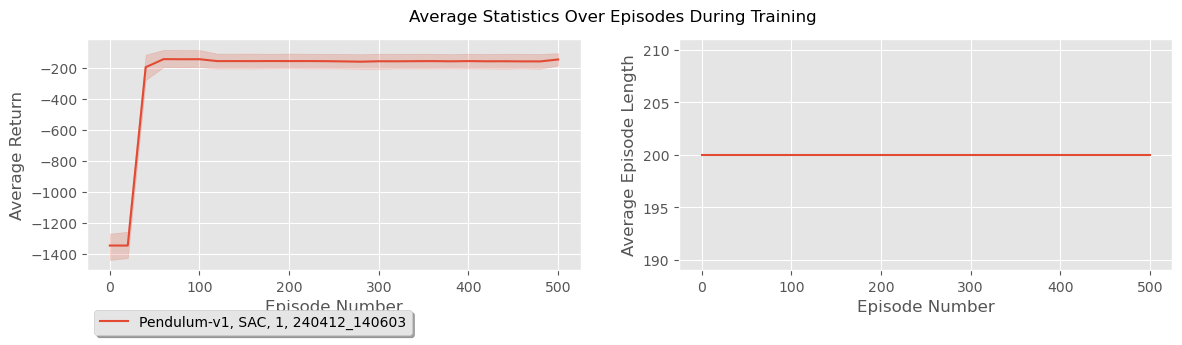

In [9]:
eval_params = edict()  # eval_params - evaluation settings for trained agent

eval_params.run_name00 = exp.run_name
eval_params.exp_type00 = exp.exp_type

# eval_params.run_name01 = "CartPole-v1__PPO__1__230302_224624"
# eval_params.exp_type01 = None

# eval_params.run_name02 = "CartPole-v1__PPO__1__230302_221245"
# eval_params.exp_type02 = None

agent_labels = []

episode_axis_limit = None

hf.plotter_agents_training_stats(eval_params, agent_labels, episode_axis_limit, plot_returns=True, plot_episode_len=True)

## TensorBoard Inline

In [10]:
# %load_ext tensorboard
# %tensorboard --logdir runs --host localhost